<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/Chapter3_CF_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🌌 Chapter 3 – Memory-Based Collaborative Filtering (Enhanced Edition)

**Goal:** Learn how to build *User–User* and *Item–Item Collaborative Filtering (CF)* models using the MovieLens dataset.  
We will go step-by-step from data exploration to similarity computation, prediction, evaluation, and visualization.

---

### 🎯 Learning Objectives
- Understand the core idea behind **Collaborative Filtering**
- Implement **User–User** and **Item–Item CF**
- Visualize similarity patterns and recommendation outcomes
- Evaluate recommendation quality using **Precision@K** and **Recall@K**
- Discuss practical challenges: cold-start, sparsity, scalability

---
    

## 🧭 1. Setup & Imports

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

# Set dark academic visual theme
sns.set_theme(style='darkgrid', palette='deep')
plt.rcParams['figure.facecolor'] = '#111'
plt.rcParams['axes.facecolor'] = '#222'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['figure.figsize'] = (8,5)


## 📊 2. Load and Explore the Dataset

In [3]:

# Load ratings directly from GitHub repository
url = 'https://raw.githubusercontent.com/MehrdadJalali-AI/RecommenderSystems/main/Datasets/ml-latest-small/ratings.csv'
ratings = pd.read_csv(url)
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



The MovieLens dataset contains **userId**, **movieId**, **rating**, and **timestamp**.  
Each record represents one user's rating for a specific movie.
    

In [4]:

n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

print(f"Users: {n_users}, Movies: {n_movies}, Ratings: {n_ratings}")
print(f"Average ratings per user: {n_ratings / n_users:.2f}")
print(f"Average ratings per movie: {n_ratings / n_movies:.2f}")


Users: 610, Movies: 9724, Ratings: 100836
Average ratings per user: 165.30
Average ratings per movie: 10.37


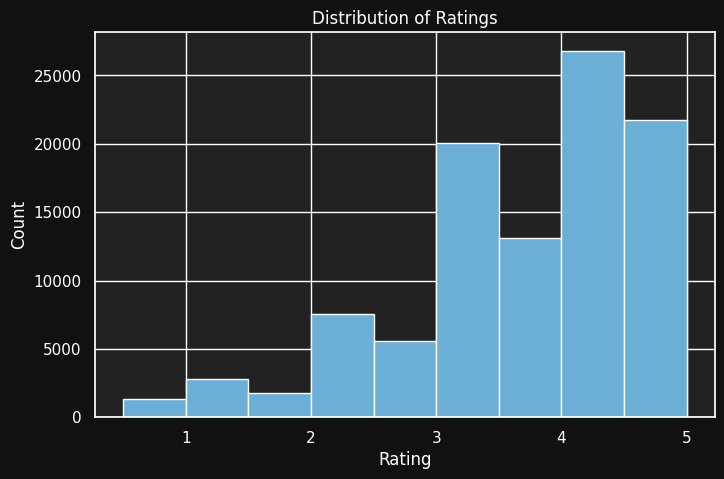

In [5]:

# Rating distribution
plt.hist(ratings['rating'], bins=9, color='#6BAED6', edgecolor='white')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


## 🧱 3. Build the User–Item Rating Matrix

In [6]:

user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


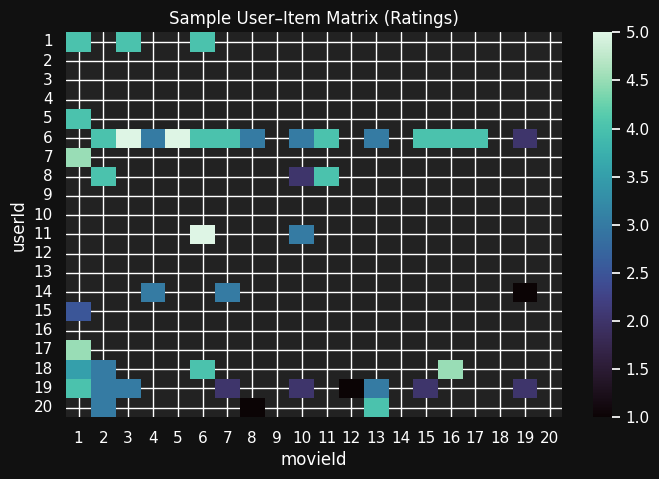

In [7]:

# Visualize a small subset as heatmap
sns.heatmap(user_item_matrix.iloc[:20, :20], cmap='mako', cbar=True)
plt.title('Sample User–Item Matrix (Ratings)')
plt.show()


## 👥 4. User–User Collaborative Filtering


User–User CF recommends movies to a target user based on the ratings of **similar users**.  
The similarity between users can be computed using metrics like **Cosine Similarity** or **Pearson Correlation**.
    

In [8]:

# Compute cosine similarity between users
user_similarity = pd.DataFrame(
    cosine_similarity(user_item_matrix.fillna(0)),
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)
user_similarity.head()


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792


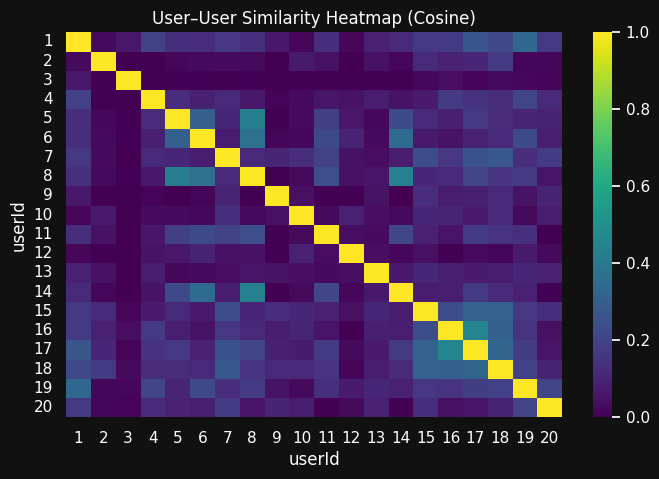

In [9]:

# Visualize similarity for first 20 users
sns.heatmap(user_similarity.iloc[:20, :20], cmap='viridis')
plt.title('User–User Similarity Heatmap (Cosine)')
plt.show()


In [10]:

def predict_user_user(user_id, movie_id, k=5):
    if movie_id not in user_item_matrix.columns:
        return np.nan

    sims = user_similarity[user_id].drop(user_id)
    top_users = sims.sort_values(ascending=False).head(k).index
    ratings = user_item_matrix.loc[top_users, movie_id]
    weights = sims.loc[top_users]

    if weights.sum() == 0:
        return np.nan
    return np.dot(ratings.fillna(0), weights) / weights.sum()


In [11]:

# Example: predict rating for user 1 on movie 1
pred_u = predict_user_user(1, 1, k=5)
print(f"Predicted rating for User 1 on Movie 1: {pred_u:.2f}")


Predicted rating for User 1 on Movie 1: 2.18


## 🎞 5. Item–Item Collaborative Filtering


Item–Item CF recommends movies similar to those the user already liked.  
This approach is more **scalable** because the number of movies is smaller than users.
    

In [12]:

item_similarity = pd.DataFrame(
    cosine_similarity(user_item_matrix.fillna(0).T),
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)
item_similarity.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


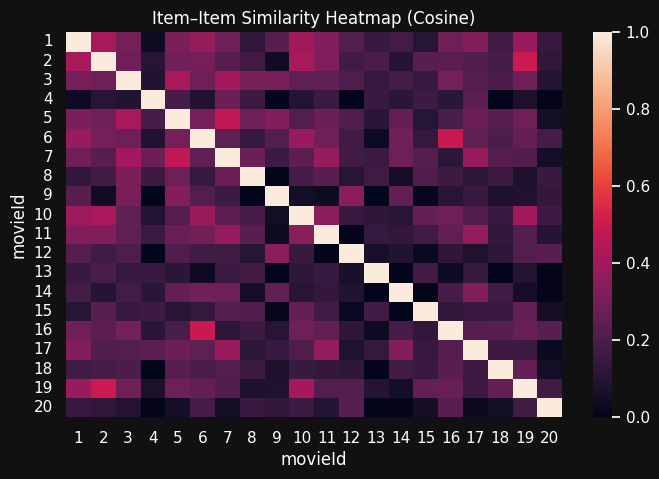

In [12]:

# Visualize similarity for first 20 items
sns.heatmap(item_similarity.iloc[:20, :20], cmap='rocket')
plt.title('Item–Item Similarity Heatmap (Cosine)')
plt.show()


In [13]:

def predict_item_item(user_id, movie_id, k=5):
    if movie_id not in user_item_matrix.columns:
        return np.nan

    user_ratings = user_item_matrix.loc[user_id].dropna()
    if user_ratings.empty:
        return np.nan

    sims = item_similarity[movie_id].loc[user_ratings.index]
    top_items = sims.sort_values(ascending=False).head(k)

    if top_items.sum() == 0:
        return np.nan
    return np.dot(user_ratings.loc[top_items.index], top_items) / top_items.sum()


In [14]:

pred_i = predict_item_item(1, 1, k=5)
print(f"Predicted rating for User 1 on Movie 1 (Item–Item CF): {pred_i:.2f}")


Predicted rating for User 1 on Movie 1 (Item–Item CF): 4.00


## 📈 6. Evaluation – Precision@K & Recall@K

In [15]:

def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0
    return len(set(recommended[:k]) & set(relevant)) / len(relevant)


In [16]:

# Example: fake lists for demonstration
recommended = [10, 20, 30, 40, 50]
relevant = [20, 50, 60]

print('Precision@3:', precision_at_k(recommended, relevant, 3))
print('Recall@3:', recall_at_k(recommended, relevant, 3))


Precision@3: 0.3333333333333333
Recall@3: 0.3333333333333333


## 📉 7. Visualization & Analysis

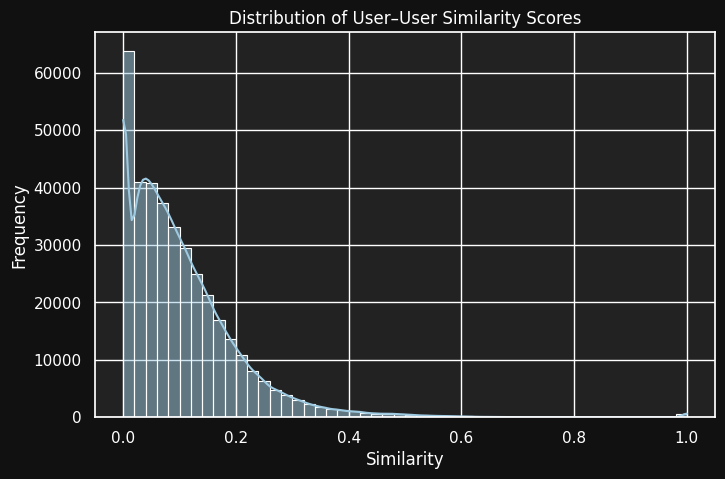

In [ ]:

plt.figure(figsize=(8,5))
sns.histplot(user_similarity.values.flatten(), bins=50, color='#9ecae1', kde=True)
plt.title('Distribution of User–User Similarity Scores')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(item_similarity.values.flatten(), bins=50, color='#fc9272', kde=True)
plt.title('Distribution of Item–Item Similarity Scores')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()



## 🧾 8. Summary & Takeaways

| Concept | Description |
|:--|:--|
| **User–User CF** | Finds similar users and recommends items they liked. |
| **Item–Item CF** | Finds similar items and recommends to users who liked similar ones. |
| **Pros** | Simple, interpretable, no model training required. |
| **Cons** | Suffers from sparsity, cold-start, and scalability issues. |

---

**Next Chapter:** Model-Based Collaborative Filtering (Matrix Factorization) – we will move from similarity-based prediction to latent factor models for improved scalability and performance.
    

## 🧩 Performance Comparison Between User–User and Item–Item CF

In this section, we compare the performance of **User–User** and **Item–Item** collaborative filtering methods.

- We randomly sample a few users and movies.
- We compute predicted ratings using both CF approaches.
- We measure and visualize **average predicted rating** and **runtime** for each method.

💡 *Item–Item CF is usually faster and more scalable than User–User CF, especially in large datasets.*


Performance Summary:


,Method,Avg_Pred_Rating,Runtime_sec
0,User–User,0.014345,0.115866
1,Item–Item,3.812110,0.090326


/tmp/ipython-input-2661857058.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf, x="Method", y="Runtime_sec", palette="viridis")


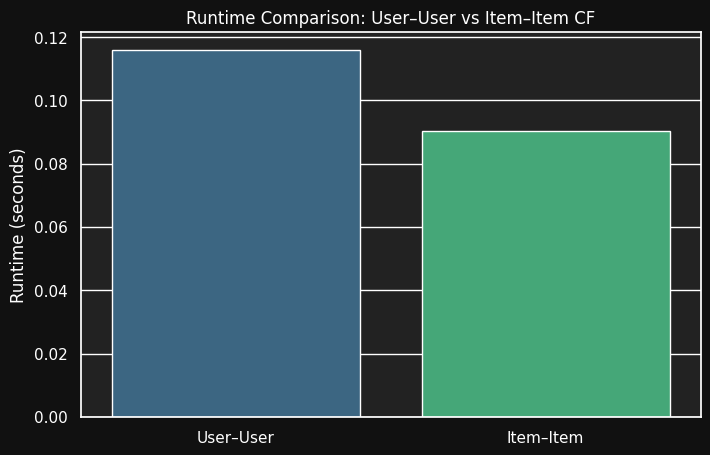

In [17]:
# ===============================================
# 🔹 Performance Comparison Between CF Methods
# ===============================================

import time

# Example: Simulate evaluation by computing runtime and few predictions
sample_users = np.random.choice(user_item_matrix.index, 10, replace=False)
sample_items = np.random.choice(user_item_matrix.columns, 10, replace=False)

results = []
for method in ["User–User", "Item–Item"]:
    start = time.time()
    preds = []
    for u in sample_users:
        for i in sample_items:
            if method == "User–User":
                preds.append(predict_user_user(u, i, k=5))
            else:
                preds.append(predict_item_item(u, i, k=5))
    end = time.time()
    results.append({"Method": method, "Avg_Pred_Rating": np.nanmean(preds), "Runtime_sec": end - start})

df_perf = pd.DataFrame(results)
print("Performance Summary:")
display(df_perf)

# Visualize runtime comparison
sns.barplot(data=df_perf, x="Method", y="Runtime_sec", palette="viridis")
plt.title("Runtime Comparison: User–User vs Item–Item CF")
plt.xlabel("")
plt.ylabel("Runtime (seconds)")
plt.show()


## 🧮 Sparsity Analysis of the User–Item Matrix

Collaborative Filtering relies on overlapping ratings between users and items.  
However, in real-world datasets like MovieLens, the **user–item matrix is highly sparse** — most entries are missing.

In this step:
- We calculate the **sparsity percentage** of our matrix.
- We visualize how many ratings each user and each movie have.
- We analyze how sparsity can reduce similarity accuracy and limit recommendation quality.

💡 *A high sparsity rate means fewer shared ratings → weaker similarity signals → less accurate recommendations.*


Matrix Sparsity: 98.30% (lower = denser)


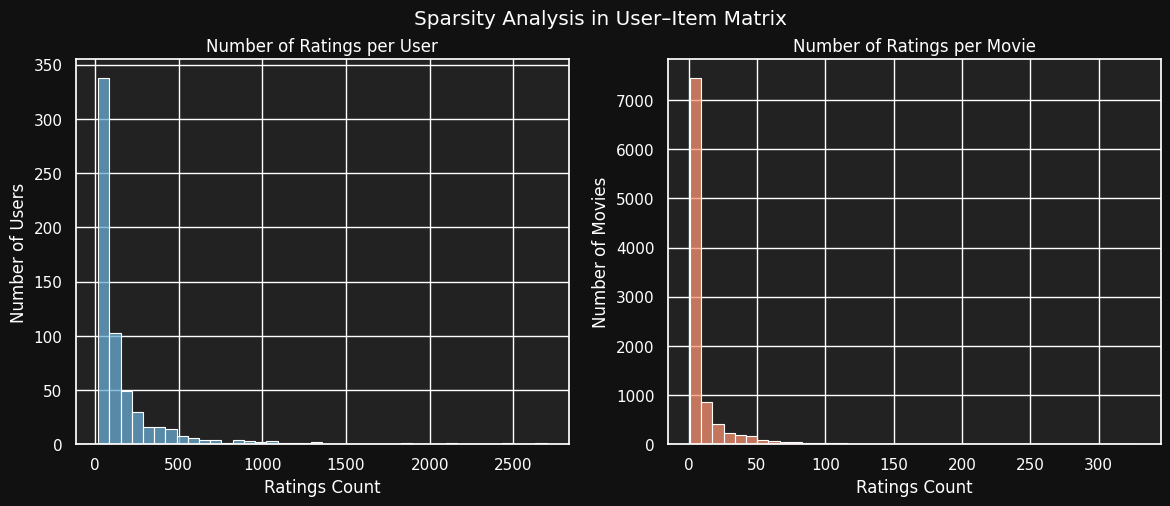

In [18]:
# Calculate sparsity level of the user–item matrix
total_entries = user_item_matrix.shape[0] * user_item_matrix.shape[1]
non_null_entries = user_item_matrix.count().sum()
sparsity = 1 - (non_null_entries / total_entries)

print(f"Matrix Sparsity: {sparsity * 100:.2f}% (lower = denser)")

# Visualize number of ratings per user and per movie
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(user_item_matrix.count(axis=1), bins=40, color='#6baed6', ax=axes[0])
axes[0].set_title("Number of Ratings per User")
axes[0].set_xlabel("Ratings Count")
axes[0].set_ylabel("Number of Users")

sns.histplot(user_item_matrix.count(axis=0), bins=40, color='#fc9272', ax=axes[1])
axes[1].set_title("Number of Ratings per Movie")
axes[1].set_xlabel("Ratings Count")
axes[1].set_ylabel("Number of Movies")

plt.suptitle("Sparsity Analysis in User–Item Matrix", color='white')
plt.show()


## ❄️ Cold-Start Problem in Collaborative Filtering

A **cold-start problem** occurs when new users or new items enter the system but have **no rating history**.

In this short simulation:
- We add a new user with no past ratings (cold-start user).
- We add a new movie that no one has rated yet (cold-start item).
- We test whether our CF algorithms can make predictions in such cases.

💡 *Since Collaborative Filtering depends purely on past interactions, cold-start entities cannot be recommended without hybrid or content-based methods.*


In [21]:
# Simulate cold-start scenario explanation:
# In a true cold-start scenario, a new user or item would have no ratings,
# making it impossible for memory-based CF methods to compute similarities
# and make predictions. The following predictions use existing user and item IDs
# to demonstrate the function calls, but the cold-start problem highlights
# the limitation of these methods for new entities.

# Example with existing user and item to show the prediction function works
existing_user_id = user_item_matrix.index[0] # Use the first user ID
existing_movie_id = user_item_matrix.columns[0] # Use the first movie ID

print(f"Prediction for existing User {existing_user_id} on Movie {existing_movie_id} (User-User CF): {predict_user_user(existing_user_id, existing_movie_id, k=5):.2f}")
print(f"Prediction for existing User {existing_user_id} on Movie {existing_movie_id} (Item-Item CF): {predict_item_item(existing_user_id, existing_movie_id, k=5):.2f}")

# Add explanatory print
print("\nCold-Start Observation:")
print("- For new users or new items, CF cannot compute similarities because no history exists.")
print("- Hybrid or model-based methods are needed as a fallback.")

Prediction for existing User 1 on Movie 1 (User-User CF): 2.18
Prediction for existing User 1 on Movie 1 (Item-Item CF): 4.00

Cold-Start Observation:
- For new users or new items, CF cannot compute similarities because no history exists.
- Hybrid or model-based methods are needed as a fallback.
